In [78]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

plt.rcParams['figure.figsize'] = [18, 9] #figure size
plt.rcParams.update({'font.size': 22}) # caption size

In [79]:
def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

In [80]:
def mse(outputs, targets):
    return np.mean(np.square(outputs - targets))

def accuracy(outputs, targets):
    #print(outputs.shape)
    class_predictions = np.array([[1.0 if p > 0.0 else -1.0 for p in p_row] for p_row in outputs])
    return 1.0 - np.count_nonzero(class_predictions - targets)/class_predictions.size

In [81]:
def split(samples, testfraction = 0.5):
    indices = np.random.permutation(len(samples))
    separator_index = int(np.ceil(len(indices) * testfraction))
    train_indices, test_indices = indices[separator_index:], indices[:separator_index]
    return samples[train_indices], samples[test_indices]

# 2-layer neural network with batch learning and delta rule

In [151]:
class multi_layer_neural_network:
    def __init__(self):
        self.w = None #weigths to the hidden layer
        self.v = None #weights from the hidden layer

    def fit(self, patterns, targets, hidden_nodes, epochs=100, learning_rate=0.01, alpha=0.9):
        patterns = self.append_bias(patterns)

        self.init_weights(patterns.shape[0], targets.shape[0], hidden_nodes)
        squared_errors = []
        accuracies = []

        tetha = np.zeros(self.w.shape, "float")
        psi = np.zeros(self.v.shape, "float")
        for i in range(epochs):
            h_in = self.w @ patterns
            h_in_1 = self.append_bias(h_in)
            h_out = self.activation_function(h_in)
            h_out = self.append_bias(h_out)

            o_in = self.v @ h_out
            o_out = self.activation_function(o_in)
            
            #why o_out and h_out here? Why o_out - targets
            delta_o = (o_out - targets) * ((1.0 + o_out) * (1.0 - o_out)) * 0.5
            delta_h = (self.v.T * delta_o) * ((1.0 + h_out) * (1.0 - h_out)) * 0.5
            delta_h = delta_h[:-1]

            tetha = -delta_h @ patterns.T if i == 0 else alpha * tetha - (1.0 - alpha) * delta_h @ patterns.T
            #tetha = alpha * tetha - (1.0 - alpha) * delta_h @ patterns.T
            self.w += learning_rate * tetha

            psi = -delta_o @ h_out.T if i == 0 else alpha * psi - (1.0 - alpha) * delta_o @ h_out.T
            #psi = alpha * psi - (1.0 - alpha) * delta_o @ h_out.T
            self.v += learning_rate * psi
            
            squared_errors.append(mse(o_out, targets))
            accuracies.append(accuracy(o_out, targets))
        
        return squared_errors, accuracies
            
    def predict(self, samples):
        samples = self.append_bias(samples)
        h_in = self.w @ samples
        h_out = self.activation_function(h_in)
        h_out = self.append_bias(h_out)

        o_in = self.v @ h_out
        o_out = self.activation_function(o_in)
        return o_out

    def append_bias(self, patterns):
        return np.append(patterns, [np.ones(patterns.shape[1], "float")], axis=0)

    #why +1, +2?
    def init_weights(self,pattern_dim, target_dim, hidden_nodes):
        self.w = np.random.normal(loc=0.0, scale=1.0, size=(hidden_nodes+1, pattern_dim))
        self.v = np.random.normal(loc=0.0, scale=1.0, size=(target_dim, hidden_nodes+2))

    def activation_function(self, x):  # this is the activation function proposed in the lab
        return 2.0 / (1.0 + np.exp(-x)) - 1.0

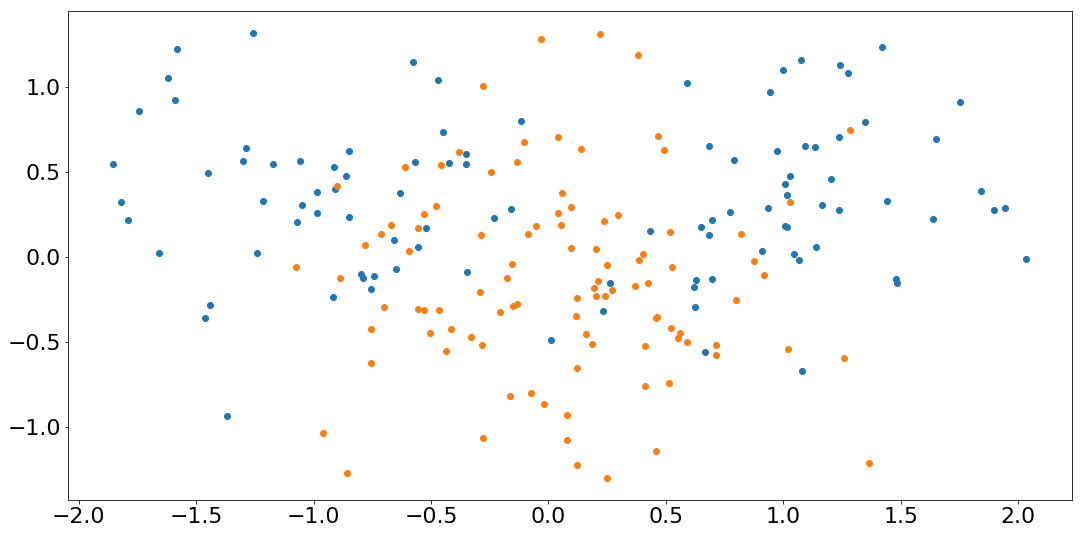

In [156]:
classA1 = np.random.multivariate_normal(mean=[1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
classA2 = np.random.multivariate_normal(mean=[-1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
classA = np.concatenate((classA1, classA2), axis=0)

classB = np.random.multivariate_normal(mean=[0.0, -0.1], cov=[[0.3, 0.0],[0.0, 0.3]], size=100)


samples = np.concatenate((classA, classB), axis=0)
targets = 100 *[1.0] + 100* [-1.0]
targets = np.reshape(targets, (len(targets), 1))
plt.plot(classA.T[0], classA.T[1], 'o')
plt.plot(classB.T[0], classB.T[1], 'o')

shuffled_index = np.random.permutation(200)

samples = samples[shuffled_index].T
targets = targets[shuffled_index].T

## 10 hidden nodes

In [166]:
multi_layer_nn = multi_layer_neural_network()
squared_errors10, accuracies10 = multi_layer_nn.fit(samples, targets, hidden_nodes=10)

## 2 hidden nodes

In [167]:
multi_layer_nn = multi_layer_neural_network()
squared_errors2, accuracies2 = multi_layer_nn.fit(samples, targets, hidden_nodes=2)

## Plotting errors against each other

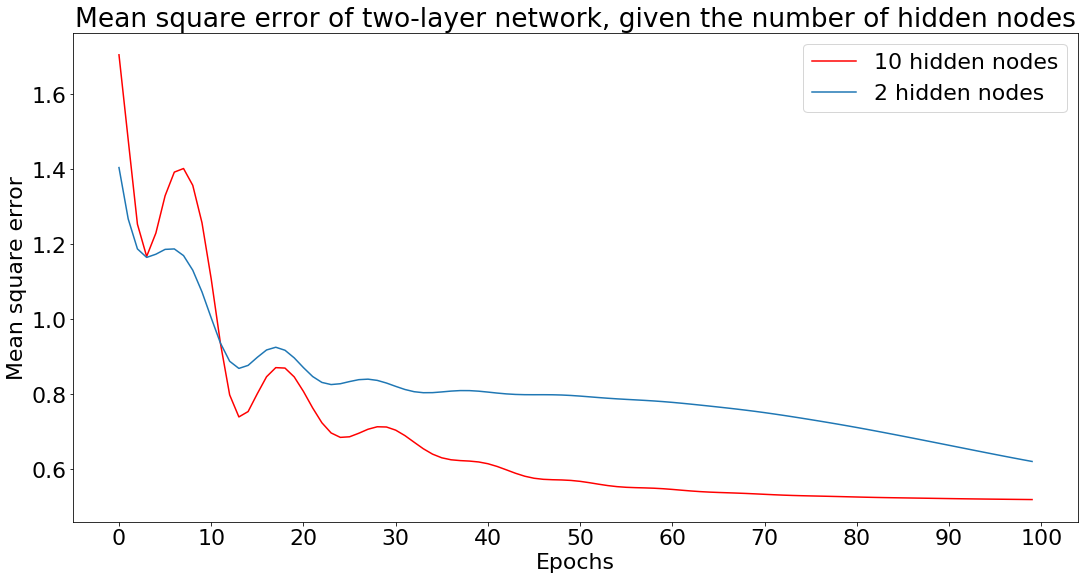

In [172]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean square error')

indices = range(0, len(squared_errors10))
plt.xticks(np.arange(0, len(squared_errors10)+1, 10))
plt.plot(indices, squared_errors10, 'r-')
plt.plot(indices, squared_errors2)
plt.grid()
plt.legend(('10 hidden nodes', '2 hidden nodes'),loc='upper right')
plt.title('Mean square error of two-layer network, given the number of hidden nodes')
plt.show()

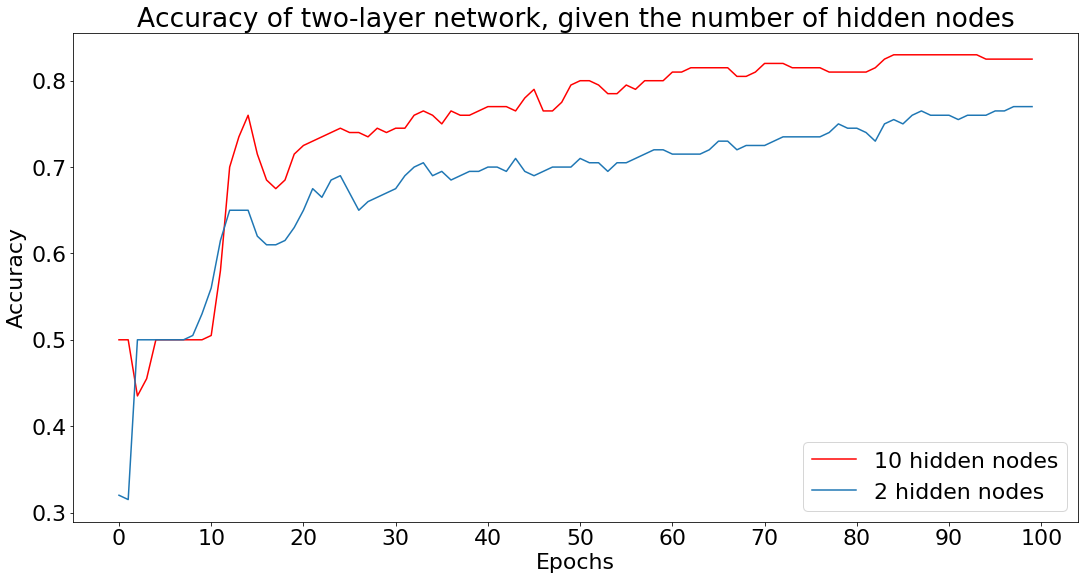

In [193]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

indices = range(0, len(accuracies10))
plt.xticks(np.arange(0, len(accuracies10)+1, 10))
plt.plot(indices, accuracies10,'r-' )
plt.plot(indices, accuracies2)
plt.legend(('10 hidden nodes', '2 hidden nodes'),loc='lower right')
plt.title('Accuracy of two-layer network, given the number of hidden nodes')
plt.show()

The more hidden nodes we have, the more complex our classifier can be, thus the more complex data it can fit. However, if we use too much hidden nodes for a simple problem, that can cause overfitting.

## Trying to get perfect results

In [117]:
multi_layer_nn = multi_layer_neural_network()
squared_errors, accuracies = multi_layer_nn.fit(samples, targets, hidden_nodes=10, epochs=400, learning_rate=0.01, alpha=0.9)

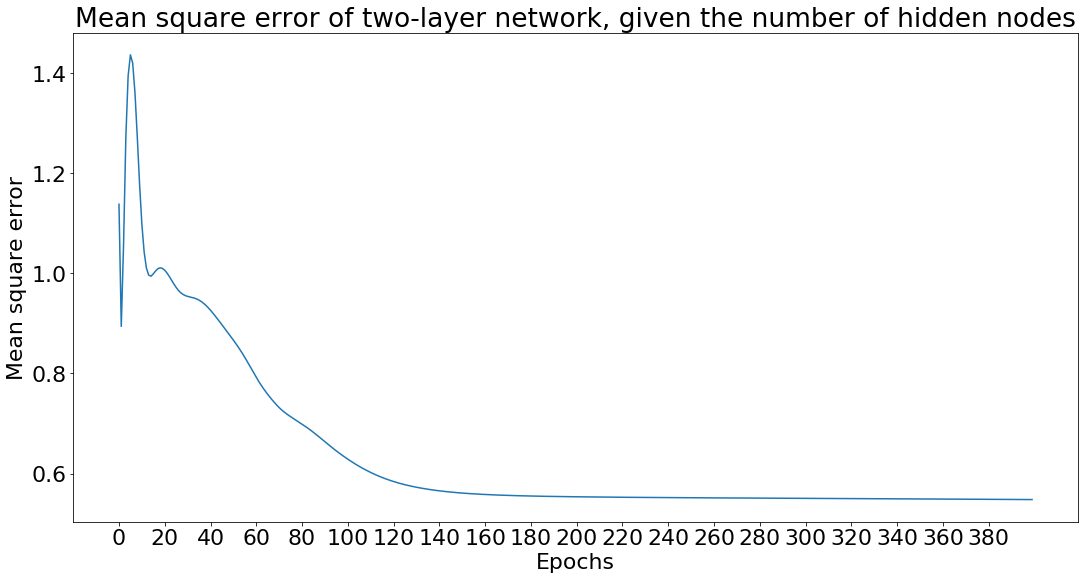

In [118]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean square error')

plt.xticks(np.arange(0, len(squared_errors), 20.0))
plt.plot(range(0, len(squared_errors)), squared_errors)
#plt.plot(indices, squared_errors, 'r-')
#plt.legend(('10 hidden nodes', '2 hidden nodes'),loc='upper right')
plt.title('Mean square error of two-layer network, given the number of hidden nodes')
plt.show()

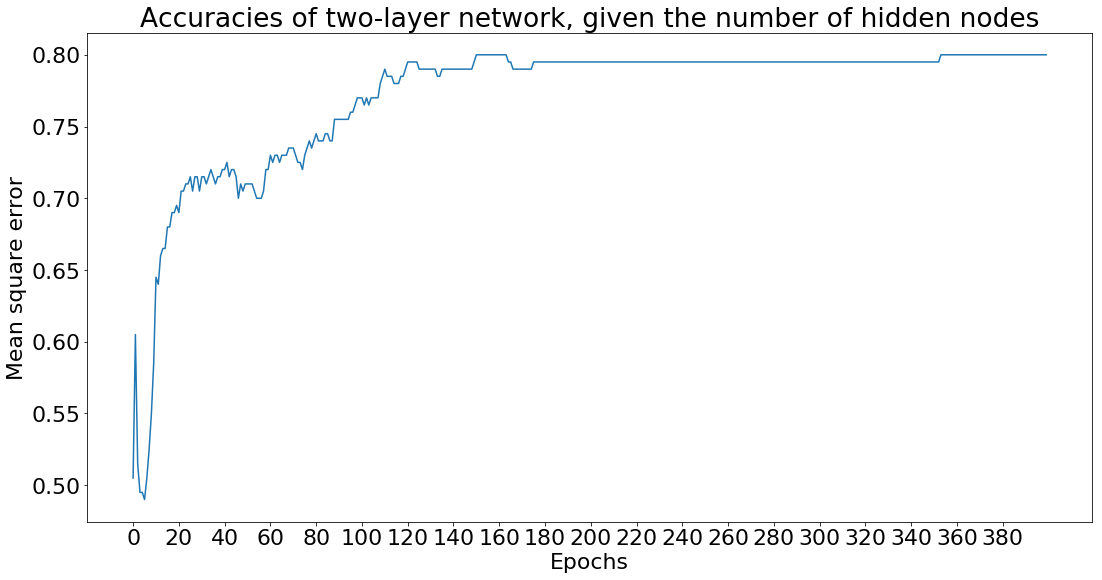

In [119]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean square error')

plt.xticks(np.arange(0, len(accuracies), 20.0))
plt.plot(range(0, len(accuracies)), accuracies)
#plt.plot(indices, squared_errors, 'r-')
#plt.legend(('10 hidden nodes', '2 hidden nodes'),loc='upper right')
plt.title('Accuracies of two-layer network, given the number of hidden nodes')
plt.show()

While using delta rule, we are minimizing the mean square error, which does not take into account the class predictions. Thus, with the delta rule, we will never reach perfect class predictions in this case. 

# Approximated Function

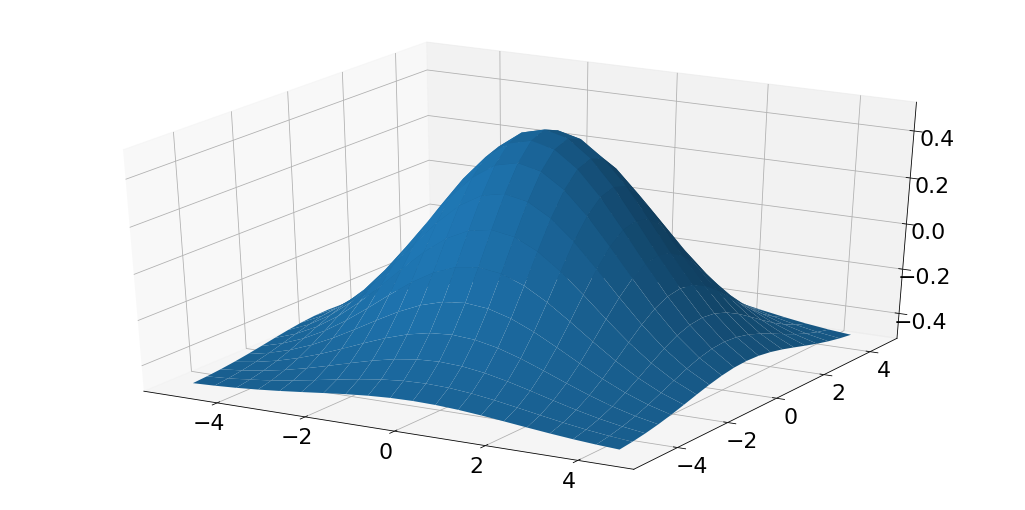

In [199]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
x = []
y = []
targets = []
for i in range(-50, 50, 5):
    for j in range(-50, 50, 5):
        x.append(i/10.0)
        y.append(j/10.0)
        targets.append(np.exp(-1*(((i/10.0)**2+(j/10.0)**2)/10)) - 0.5)
x = np.array(x)
y = np.array(y)
targets = np.array(targets)
samples = np.column_stack([x,y])
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-5, 5, 0.5)
Y = np.arange(-5, 5, 0.5)
X, Y = np.meshgrid(X, Y)
T = np.exp(-1*(X**2+Y**2)/10)-0.5
p = ax.plot_surface(X, Y, T)
targets = np.reshape(targets, (400, 1))
shuffled_index = np.random.permutation(200)
samples = samples[shuffled_index].T
targets = targets[shuffled_index].T
plt.show()

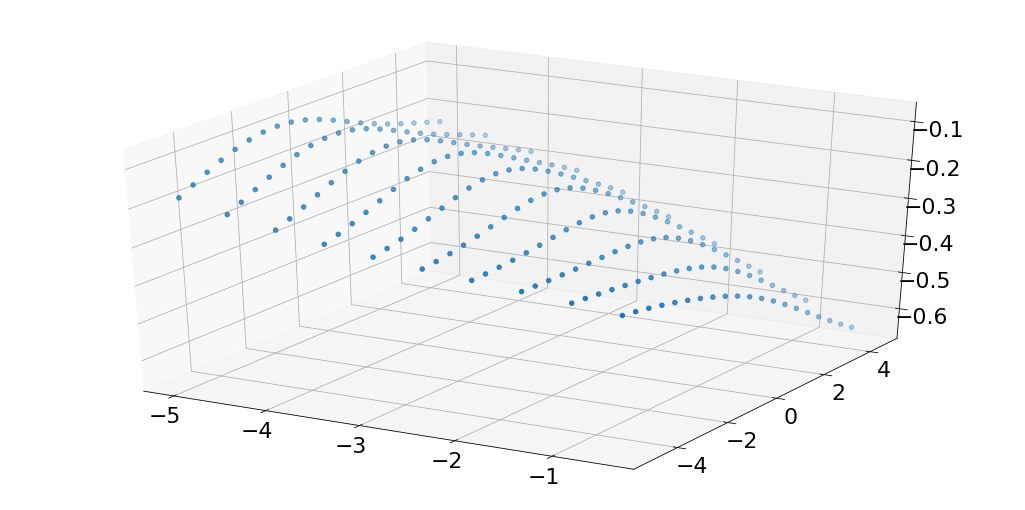

In [240]:
multi_layer_nn = multi_layer_neural_network()
squared_errors, accuracies = multi_layer_nn.fit(samples, targets, hidden_nodes=2, epochs=100, learning_rate=0.001, alpha=0.9)
multi_layer_nn_1 = multi_layer_neural_network()
squared_errors_1, accuracies_1 = multi_layer_nn_1.fit(samples, targets, hidden_nodes=4, epochs=100, learning_rate=0.001, alpha=0.9)
multi_layer_nn_2 = multi_layer_neural_network()
squared_errors_2, accuracies_2 = multi_layer_nn_2.fit(samples, targets, hidden_nodes=6, epochs=100, learning_rate=0.001, alpha=0.9)
multi_layer_nn_3 = multi_layer_neural_network()
squared_errors_3, accuracies_3 = multi_layer_nn_3.fit(samples, targets, hidden_nodes=8, epochs=100, learning_rate=0.001, alpha=0.9)
multi_layer_nn_4 = multi_layer_neural_network()
squared_errors_4, accuracies_4 = multi_layer_nn_4.fit(samples, targets, hidden_nodes=10, epochs=100, learning_rate=0.001, alpha=0.9)
predictions = multi_layer_nn.predict(samples)
fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(samples[0], samples[1], predictions[0])
plt.show()

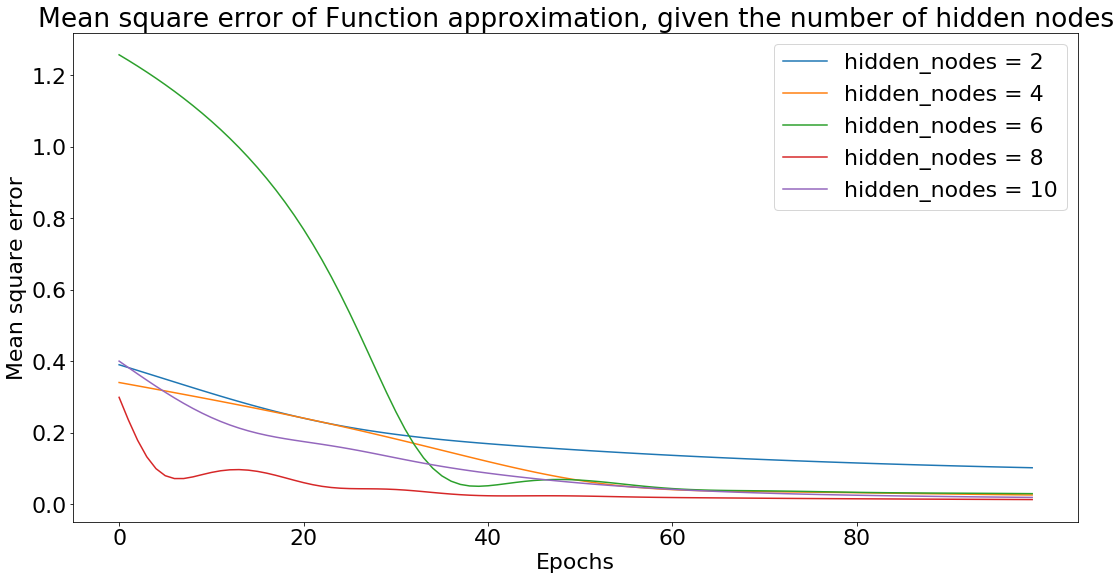

In [241]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean square error')

plt.xticks(np.arange(0, len(squared_errors), 20.0))
plt.plot(range(0, len(squared_errors)), squared_errors,label="hidden_nodes = 2")
plt.plot(range(0, len(squared_errors_1)), squared_errors_1,label="hidden_nodes = 4")
plt.plot(range(0, len(squared_errors_2)), squared_errors_2,label="hidden_nodes = 6")
plt.plot(range(0, len(squared_errors_3)), squared_errors_3,label="hidden_nodes = 8")
plt.plot(range(0, len(squared_errors_4)), squared_errors_4,label="hidden_nodes = 10")
plt.legend()
#plt.plot(indices, squared_errors, 'r-')
#plt.legend(('10 hidden nodes', '2 hidden nodes'),loc='upper right')
plt.title('Mean square error of Function approximation, given the number of hidden nodes')
plt.show()

# Traing and test set

## random 25% from each class will be test

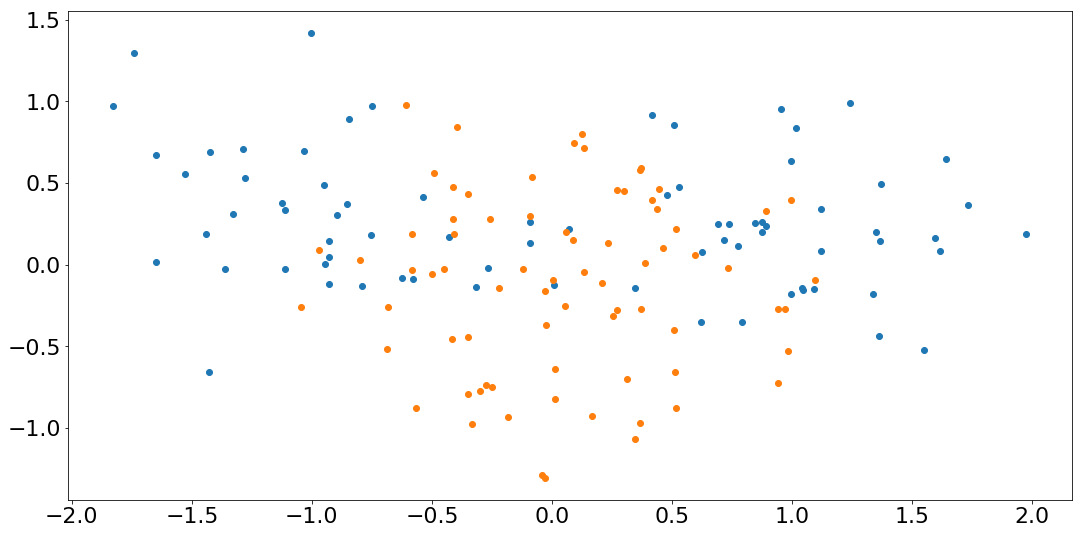

In [120]:
classA1 = np.random.multivariate_normal(mean=[1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
classA2 = np.random.multivariate_normal(mean=[-1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
classA = np.concatenate((classA1, classA2), axis=0)
classA_train, classA_test = split(classA, 0.25)

classB = np.random.multivariate_normal(mean=[0.0, -0.1], cov=[[0.3, 0.0],[0.0, 0.3]], size=100)
classB_train, classB_test = split(classB, 0.25)


samples = np.concatenate((classA_train, classB_train), axis=0)
targets = 75 *[1.0] + 75* [-1.0]
targets = np.reshape(targets, (len(targets), 1))
plt.plot(classA_train.T[0], classA_train.T[1], 'o')
plt.plot(classB_train.T[0], classB_train.T[1], 'o')

shuffled_index = np.random.permutation(150)
samples = samples[shuffled_index].T
targets = targets[shuffled_index].T

In [121]:
multi_layer_nn = multi_layer_neural_network()
squared_errors, accuracies = multi_layer_nn.fit(samples, targets, hidden_nodes=20, epochs=60, learning_rate=0.005, alpha=0.8)

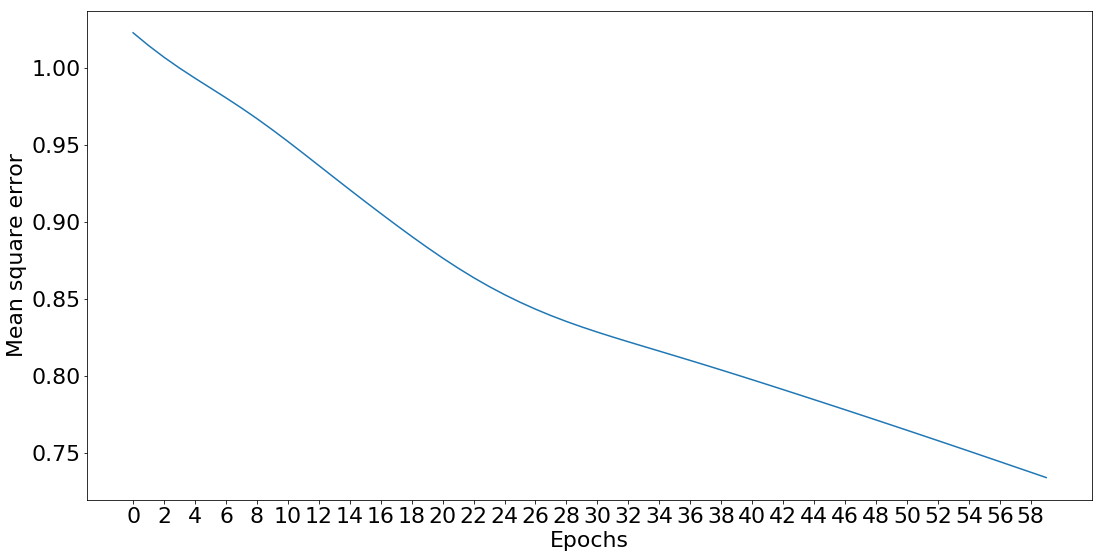

In [122]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean square error')

plt.xticks(np.arange(0, len(squared_errors), 2))
plt.plot(range(len(squared_errors)), squared_errors)
plt.show()

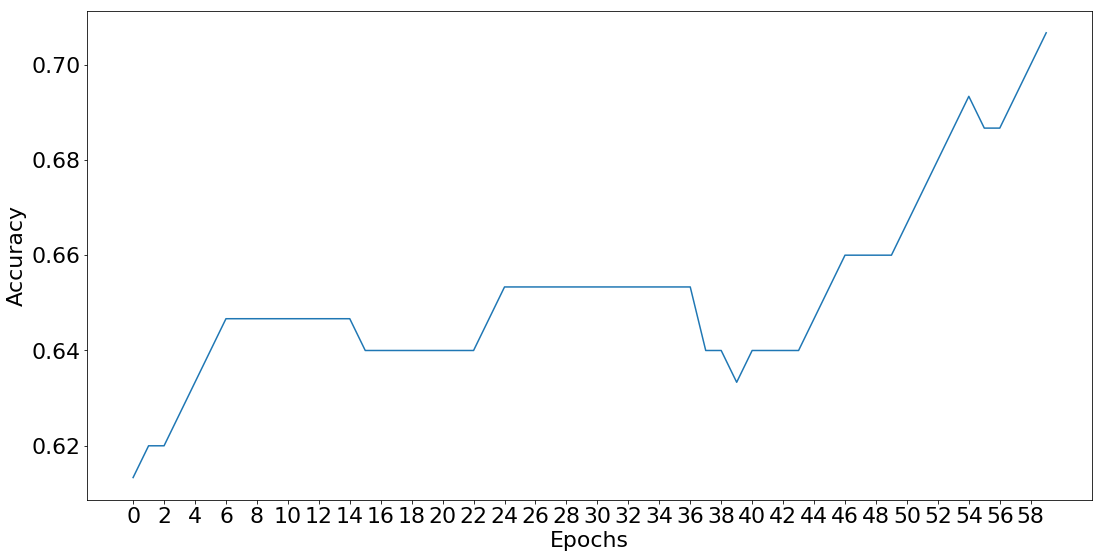

In [123]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

plt.xticks(np.arange(0, len(accuracies), 2))
plt.plot(range(len(accuracies)), accuracies)
plt.show()

(0.74, 0.6904314421977845)

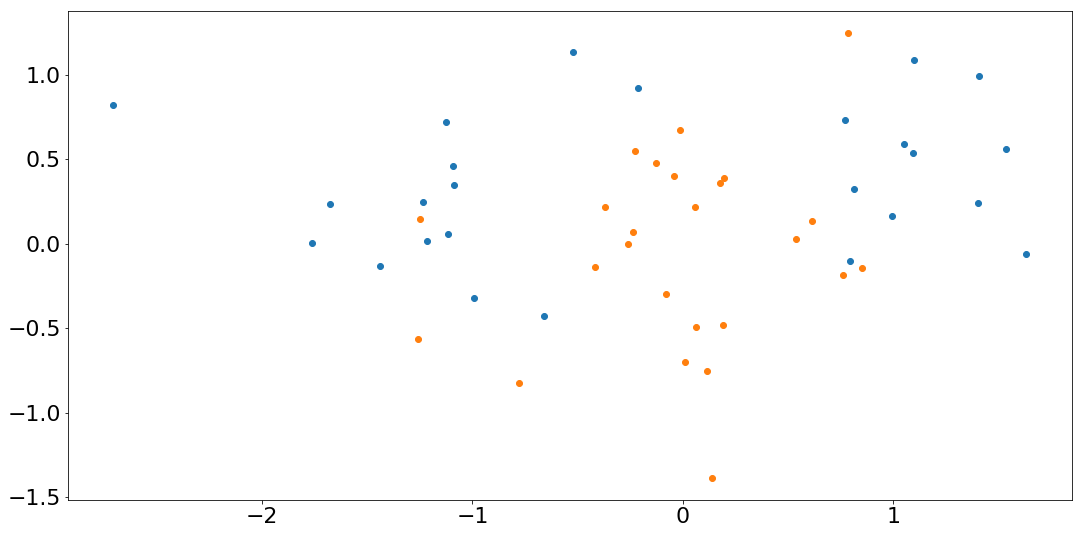

In [124]:
samples = np.concatenate((classA_test, classB_test), axis=0)
targets = 25 *[1.0] + 25* [-1.0]
targets = np.reshape(targets, (len(targets), 1))
plt.plot(classA_test.T[0], classA_test.T[1], 'o')
plt.plot(classB_test.T[0], classB_test.T[1], 'o')

shuffled_index = np.random.permutation(50)
samples = samples[shuffled_index].T
targets = targets[shuffled_index].T

test_predictions = multi_layer_nn.predict(samples)

accuracy(test_predictions, targets), mse(test_predictions, targets)

When we select 25% of each class as test samples, the performance is similar

## Random 50% from class A

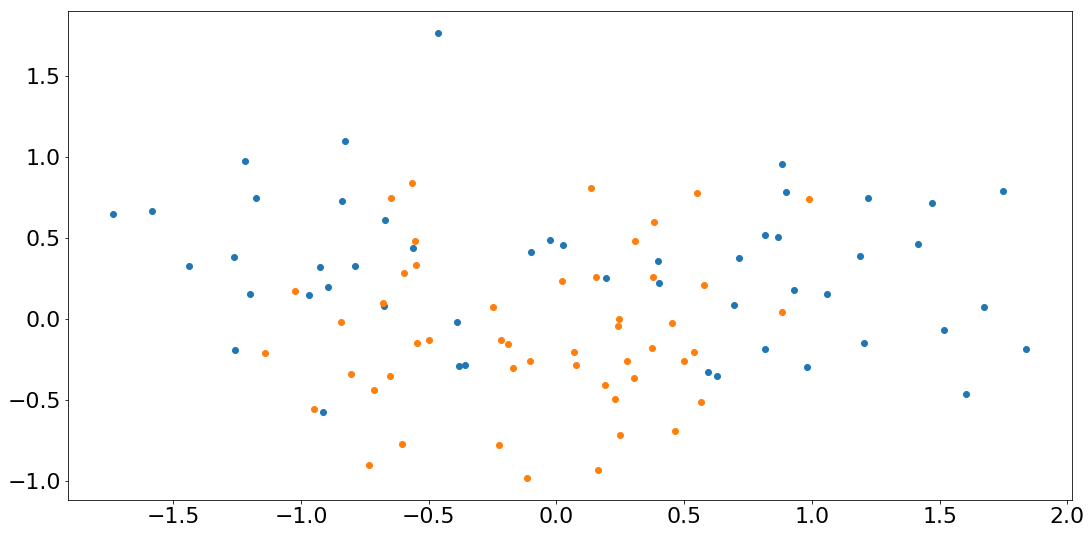

In [515]:
# classA1 = np.random.multivariate_normal(mean=[1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
# classA2 = np.random.multivariate_normal(mean=[-1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
classA = np.concatenate((classA1, classA2), axis=0)
classA_train, classA_test = split(classA, 0.5)

classB = np.random.multivariate_normal(mean=[0.0, -0.1], cov=[[0.3, 0.0],[0.0, 0.3]], size=100)


samples = np.concatenate((classA_train, classB), axis=0)
targets = 50 *[1.0] + 100* [-1.0]
targets = np.reshape(targets, (len(targets), 1))
plt.plot(classA_train.T[0], classA_train.T[1], 'o')
plt.plot(classB_train.T[0], classB_train.T[1], 'o')

shuffled_index = np.random.permutation(150)
samples = samples[shuffled_index].T
targets = targets[shuffled_index].T

In [516]:
multi_layer_nn = multi_layer_neural_network()
squared_errors, accuracies = multi_layer_nn.fit(samples, targets, hidden_nodes=5, epochs=10, learning_rate=0.01, alpha=0.9)

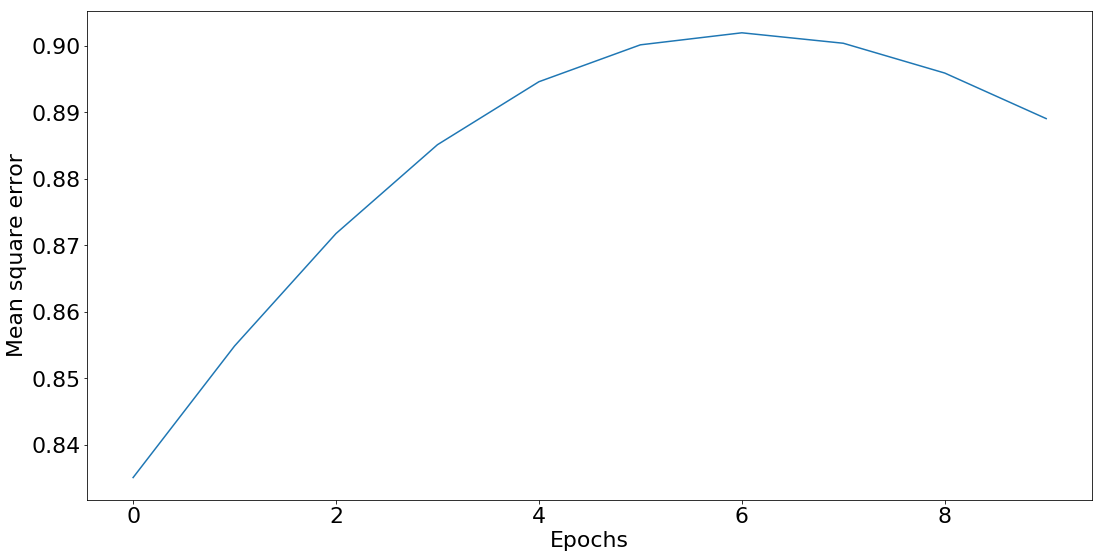

In [517]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean square error')

plt.xticks(np.arange(0, len(squared_errors), 2))
plt.plot(range(len(squared_errors)), squared_errors)
plt.show()

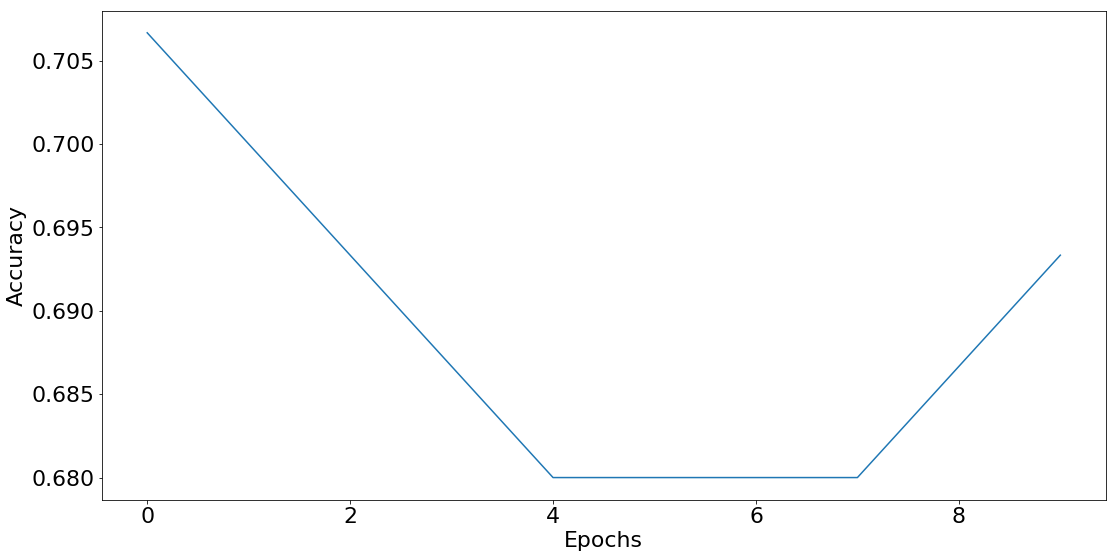

In [518]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

plt.xticks(np.arange(0, len(accuracies), 2))
plt.plot(range(len(accuracies)), accuracies)
plt.show()

(0.14, 1.8344123857164831)

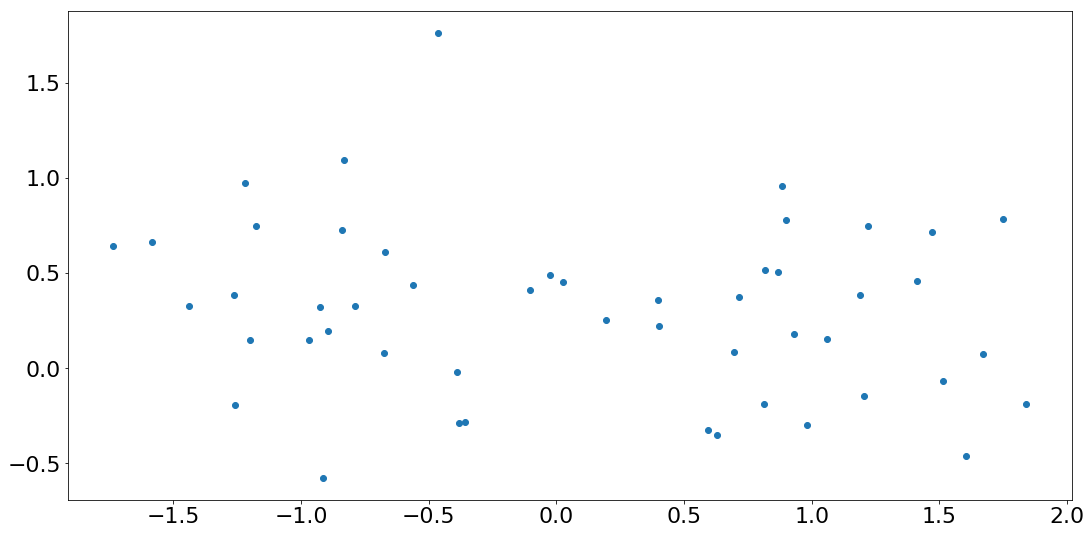

In [519]:
targets = 50 *[1.0]
targets = np.reshape(targets, (len(targets), 1))
plt.plot(classA_train.T[0], classA_train.T[1], 'o')

shuffled_index = np.random.permutation(50)
samples = classA_train[shuffled_index].T
targets = targets.T

test_predictions = multi_layer_nn.predict(samples)

accuracy(test_predictions, targets), mse(test_predictions, targets)

## Random 50% from class B

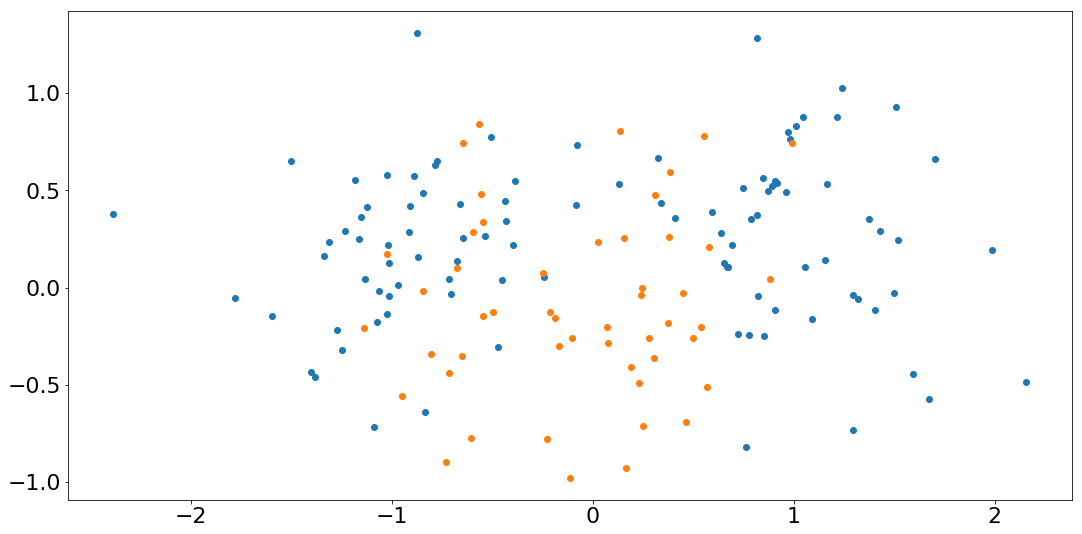

In [495]:
# classA1 = np.random.multivariate_normal(mean=[1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
# classA2 = np.random.multivariate_normal(mean=[-1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
classA = np.concatenate((classA1, classA2), axis=0)

classB = np.random.multivariate_normal(mean=[0.0, -0.1], cov=[[0.3, 0.0],[0.0, 0.3]], size=100)
classB_train, classB_test = split(classB, 0.5)


samples = np.concatenate((classA, classB_train), axis=0)
targets = 100 *[1.0] + 50* [-1.0]
targets = np.reshape(targets, (len(targets), 1))
plt.plot(classA.T[0], classA.T[1], 'o')
plt.plot(classB_train.T[0], classB_train.T[1], 'o')

shuffled_index = np.random.permutation(150)
samples = samples[shuffled_index].T
targets = targets[shuffled_index].T

In [496]:
multi_layer_nn = multi_layer_neural_network()
squared_errors, accuracies = multi_layer_nn.fit(samples, targets, hidden_nodes=5, epochs=20, learning_rate=0.001, alpha=0.9)

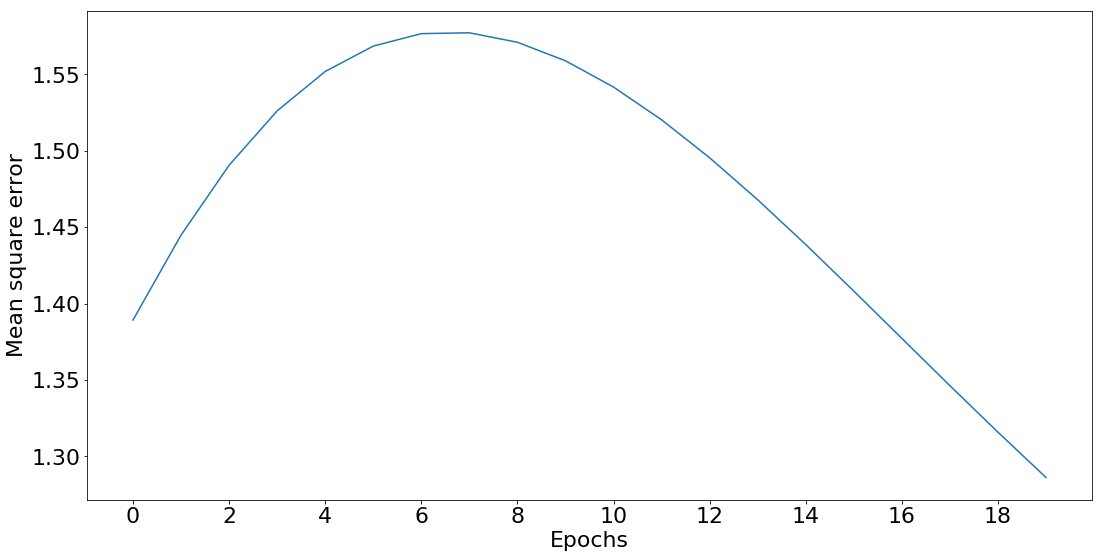

In [497]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean square error')

plt.xticks(np.arange(0, len(squared_errors), 2))
plt.plot(range(len(squared_errors)), squared_errors)
plt.show()

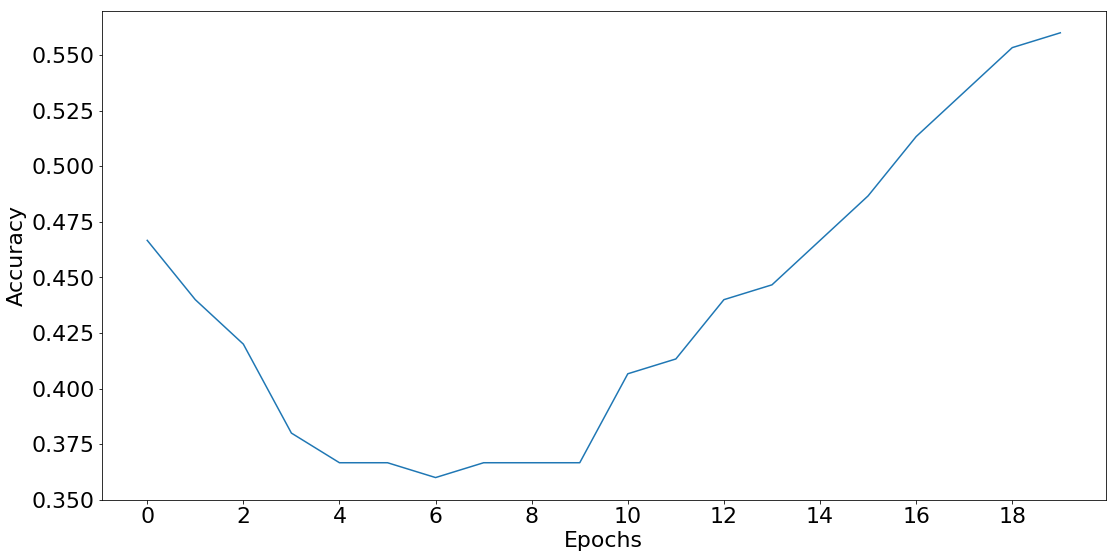

In [498]:
fig, ax = plt.subplots()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')

plt.xticks(np.arange(0, len(accuracies), 2))
plt.plot(range(len(accuracies)), accuracies)
plt.show()

(0.8, 0.584369493131923)

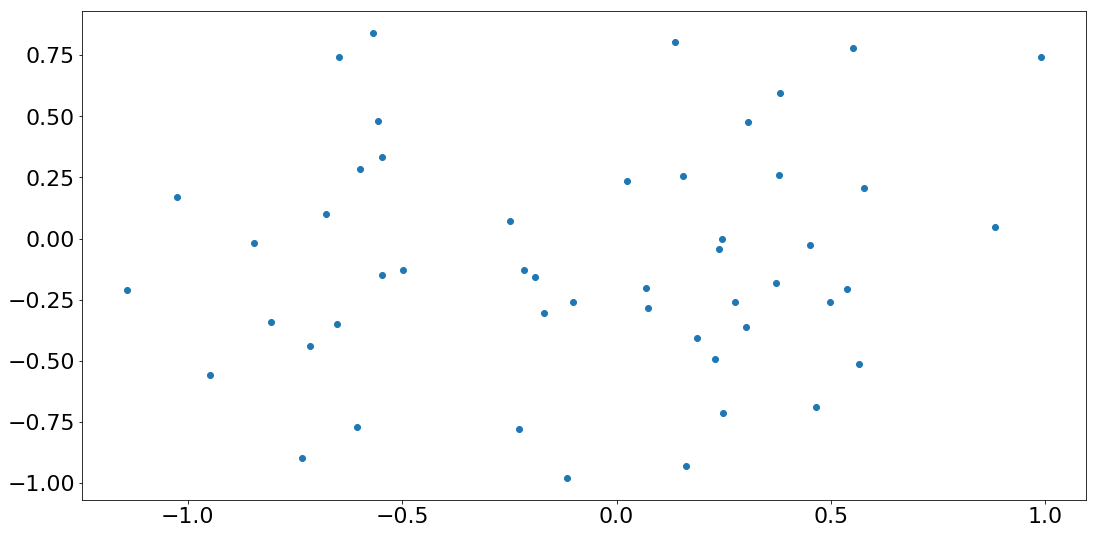

In [499]:
targets = 50 *[-1.0]
targets = np.reshape(targets, (len(targets), 1))
plt.plot(classB_train.T[0], classB_train.T[1], 'o')

shuffled_index = np.random.permutation(50)
samples = classB_train[shuffled_index].T
targets = targets.T

test_predictions = multi_layer_nn.predict(samples)

accuracy(test_predictions, targets), mse(test_predictions, targets)

When 50% of class B will be the training set, the performance is high with a simple model on the test set but low on the training set(f.e. hidden_nodes=5, epochs=20, learning_rate=0.001, alpha=0.9), with a complex model(f.e. hidden_nodes=5, epochs=100, learning_rate=0.001, alpha=0.9), the acurracy is high on the training set and low on the testset

 ## Decision boundary

ValueError: c of shape (1, 150) not acceptable as a color sequence for x with size 2, y with size 2

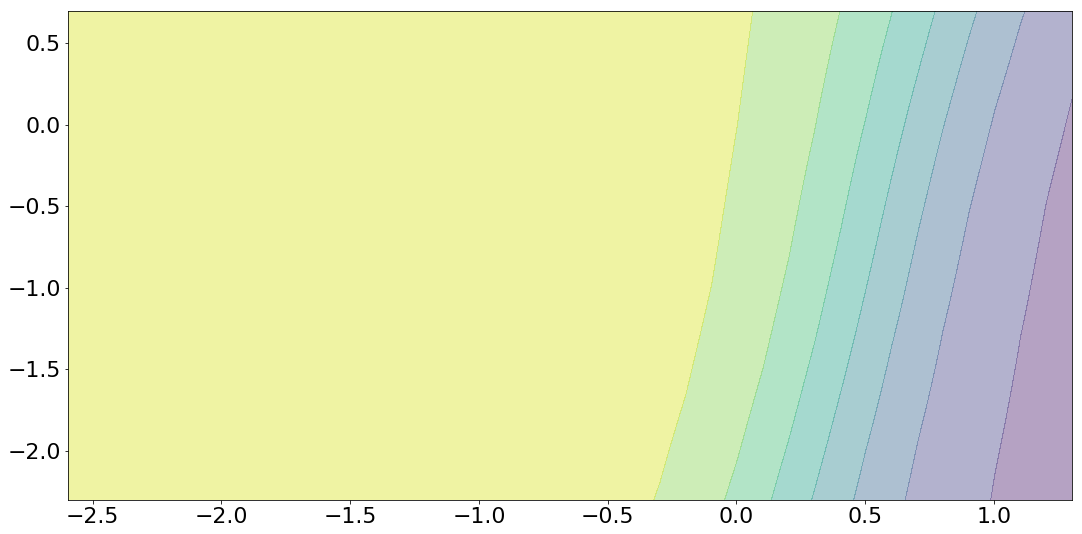

In [604]:
# classA1 = np.random.multivariate_normal(mean=[1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
# classA2 = np.random.multivariate_normal(mean=[-1.0, 0.3], cov=[[0.2, 0.0],[0.0, 0.2]], size=50)
classA = np.concatenate((classA1, classA2), axis=0)

classB = np.random.multivariate_normal(mean=[0.0, -0.1], cov=[[0.3, 0.0],[0.0, 0.3]], size=100)


samples = np.concatenate((classA, classB), axis=0)
targets = 100 *[1.0] + 100* [-1.0]
targets = np.reshape(targets, (len(targets), 1))

shuffled_index = np.random.permutation(150)
samples = samples[shuffled_index].T
targets = targets[shuffled_index].T

x_min, x_max = samples[:, 0].min() - 1, samples[:, 0].max() + 1
y_min, y_max = samples[:, 1].min() - 1, samples[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

#plt.plot(classA.T[0], classA.T[1], 'o')
#plt.plot(classB_train.T[0], classB_train.T[1], 'o')
ax = plt.gca()

multi_layer_nn = multi_layer_neural_network()
squared_errors, accuracies = multi_layer_nn.fit(samples, targets, hidden_nodes=5, epochs=10, learning_rate=0.01, alpha=0.9)


Z = multi_layer_nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(samples[:, 0], samples[:, 1], c=targets, s=20, edgecolor='k')

plt.show()